Found H proxy columns: ['H_proxy_meta', 'H_proxy_meta_smooth']

--- H_proxy_meta ---
Range: [0.183, 1.000]
Mean ± std: 0.833 ± 0.148
Missing: 177/546
Bimodality coefficient: 0.343

--- H_proxy_meta_smooth ---
Range: [0.325, 1.000]
Mean ± std: 0.833 ± 0.113
Missing: 158/546
Bimodality coefficient: 0.318


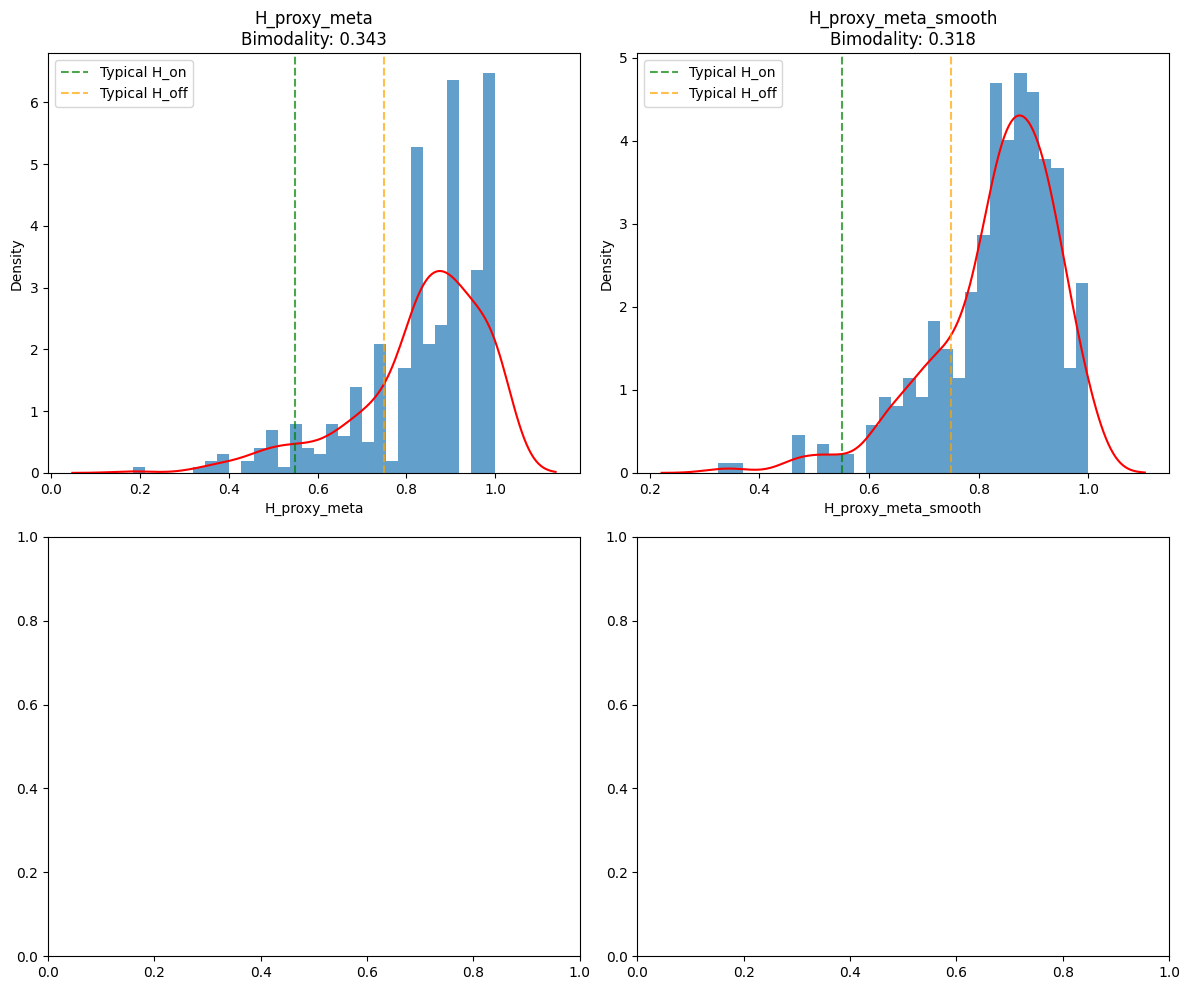


--- Butyrate Data ---
butyrate: range [18352.000, 45837819.000], mean 5801541.227 ± 4767723.176


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def validate_h_proxy():
    """Comprehensive validation of H proxy data quality"""
    df = pd.read_csv("timeseries/combined_scfas_table_scored.csv")
    
    # Find all H proxy columns
    h_cols = [c for c in df.columns if 'H_proxy' in c or 'H_' in c]
    print("Found H proxy columns:", h_cols)
    
    if not h_cols:
        print("No H proxy columns found!")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    for i, col in enumerate(h_cols):
        data = df[col].dropna()
        
        if len(data) == 0:
            print(f"Skipping {col} - no data")
            continue
            
        # Basic statistics
        print(f"\n--- {col} ---")
        print(f"Range: [{data.min():.3f}, {data.max():.3f}]")
        print(f"Mean ± std: {data.mean():.3f} ± {data.std():.3f}")
        print(f"Missing: {df[col].isna().sum()}/{len(df)}")
        print(f"Bimodality coefficient: {calculate_bimodality(data):.3f}")
        
        # Distribution plot
        row, col_idx = i // 2, i % 2
        axes[row, col_idx].hist(data, bins=30, alpha=0.7, density=True)
        axes[row, col_idx].set_title(f'{col}\nBimodality: {calculate_bimodality(data):.3f}')
        
        # Add kernel density estimate
        sns.kdeplot(data, ax=axes[row, col_idx], color='red')
        
        # Mark potential thresholds from literature
        axes[row, col_idx].axvline(0.55, color='green', linestyle='--', alpha=0.7, label='Typical H_on')
        axes[row, col_idx].axvline(0.75, color='orange', linestyle='--', alpha=0.7, label='Typical H_off')
        axes[row, col_idx].legend()
    
    plt.tight_layout()
    plt.savefig("data_validation.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # Check butyrate data too
    butyrate_cols = [c for c in df.columns if 'butyrate' in c.lower()]
    if butyrate_cols:
        print(f"\n--- Butyrate Data ---")
        for col in butyrate_cols:
            data = df[col].dropna()
            print(f"{col}: range [{data.min():.3f}, {data.max():.3f}], "
                  f"mean {data.mean():.3f} ± {data.std():.3f}")

def calculate_bimodality(data):
    """Calculate bimodality coefficient (0-1, higher = more bimodal)"""
    if len(data) < 4:
        return 0
    data = np.array(data)
    skew = ((data - data.mean()) ** 3).mean() / (data.std() ** 3 + 1e-9)
    kurtosis = ((data - data.mean()) ** 4).mean() / (data.std() ** 4 + 1e-9)
    bc = (skew ** 2 + 1) / (kurtosis + 3 * ((len(data) - 1) ** 2) / ((len(data) - 2) * (len(data) - 3)) + 1e-9)
    return min(bc, 1.0)

if __name__ == "__main__":
    validate_h_proxy()

In [2]:
# calibrate_guild_wide_search.py
import os, numpy as np, pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

INPATH = "timeseries/combined_scfas_table_scored.csv"
OUTDIR = "mw_fit_out_wide_search"; os.makedirs(OUTDIR, exist_ok=True)

# === WIDER target ranges for better exploration ===
TARGETS = {
    "u": 0.77,     "sd_u": 0.08,    # Wider uncertainty
    "K_u": 0.18,   "sd_K_u": 0.06,
    "gamma": 1.25, "sd_gamma": 0.20,
    "p_high": 3.20,"sd_p_high": 0.40,
    "rHP": 0.0344, "sd_rHP": 0.03,
}

H_COLS=["H_proxy_meta_smooth","H_proxy_meta"]
SCFA=["butyrate"]; MIN_ROWS=4
KQ=80.0; HILL_N=3
PENALTY=1e3

# Wider priors for bistability exploration
PRIOR={"r0P":(0.32,0.12),"rHP":(0.07,0.06),"r0C":(0.28,0.12),"K_M":(1.0,0.4),
       "gamma":(0.85,0.35),"c":(0.12,0.08),"d":(0.12,0.08),"g":(0.60,0.40),
       "u":(0.60,0.25),"K_u":(0.20,0.12),"p_low":(0.12,0.08),"p_high":(2.20,0.90),
       "H_on":(0.55,0.12),"H_off":(0.75,0.12),"tau_q":(5.0,3.0),"K_B":(0.20,0.12)}

# WIDER bounds around targets for bistability exploration
def band(c, w_lo, w_hi): return c - w_lo, c + w_hi
uL,uU   = band(TARGETS["u"],   0.15, 0.15)    # Much wider
KuL,KuU = band(TARGETS["K_u"], 0.10, 0.10)
gaL,gaU = band(TARGETS["gamma"], 0.35, 0.30)
pHL,pHU = band(TARGETS["p_high"], 0.80, 0.60)

# Expanded bounds for bistability
LBg=np.array([0.10, 0.00, 0.10, 0.40, gaL, 0.03, 0.02, 0.15, uL, KuL, 0.03, pHL, 0.45, 0.65, 2.0, 0.05])
UBg=np.array([0.60, 0.25, 0.60, 2.00, gaU, 0.25, 0.25, 1.50, uU, KuU, 0.30, pHU, 0.80, 0.95, 15.0, 0.40])

# Multiple starting points for better global search
STARTING_POINTS = [
    # Conservative start (close to literature)
    [0.32, 0.05, 0.28, 1.0, 1.10, 0.12, 0.08, 0.70, 0.77, 0.18, 0.12, 3.20, 0.55, 0.75, 5.5, 0.20],
    # Higher growth rates (more bistability potential)
    [0.45, 0.02, 0.35, 1.2, 1.50, 0.08, 0.05, 0.90, 0.65, 0.15, 0.08, 3.50, 0.50, 0.70, 8.0, 0.15],
    # Lower thresholds (easier switching)
    [0.28, 0.08, 0.25, 0.8, 0.90, 0.15, 0.12, 0.50, 0.85, 0.22, 0.15, 2.80, 0.60, 0.80, 4.0, 0.25]
]

# --- Data prep (same as before) ---
df=pd.read_csv(INPATH)
Hcol=next((c for c in H_COLS if c in df.columns), None)
if Hcol is None: raise ValueError("Need H proxy col")
for c in SCFA:
    if c not in df.columns: raise ValueError(f"Missing {c}")
df=df[["subject_id","sample_id",Hcol]+SCFA].dropna(subset=["subject_id","sample_id"]).copy()
df["t_idx"]=df.groupby("subject_id").cumcount().astype(float)

def robust_z(s):
    x=s.astype(float).to_numpy(); m=np.isfinite(x)
    if m.sum()==0: import pandas as pd; return pd.Series(np.zeros_like(x), index=s.index)
    xm=x[m]; med=np.median(xm); mad=np.median(np.abs(xm-med))
    scale=mad if mad>1e-9 else (np.percentile(xm,75)-np.percentile(xm,25) or np.std(xm)+1e-9)
    import pandas as pd; return pd.Series((x-med)/(scale+1e-9), index=s.index)

df["B_z"]=df.groupby("subject_id")[SCFA[0]].transform(robust_z)
df["H_obs"]=df[Hcol].clip(0,1)

subs=[]
for sid,sub in df.groupby("subject_id"):
    sub=sub.sort_values("t_idx")
    if len(sub)<MIN_ROWS: continue
    t=sub["t_idx"].to_numpy(float)
    B=sub["B_z"].to_numpy(float); H=sub["H_obs"].to_numpy(float)
    mB=np.isfinite(B); mH=np.isfinite(H)
    if mB.sum()<3 or mH.sum()<3: continue
    def first(a,d):
        import numpy as np
        a=np.asarray(a,float); idx=np.where(np.isfinite(a))[0]
        return float(a[idx[0]]) if len(idx) else float(d)
    subs.append({"sid":sid,"t":t,"B":B,"H":H,"maskB":mB,"maskH":mH,
                 "nB":int(mB.sum()),"nH":int(mH.sum()),
                 "H0":float(np.clip(first(H,0.6),0,1)),
                 "B0":float(max(0.05, first(B,0.1)))})
if not subs: raise RuntimeError("no subjects")

# --- Model (same as before) ---
def q_inf(H,q,H_on,H_off,KQ):
    th=(1-q)*H_on + q*H_off
    return 1.0/(1.0 + np.exp(-KQ*(H - th)))

def rhs(t,y,p):
    P,C,H,B,q=y
    r0P,rHP,r0C,K_M,gamma,c,d,gH,u,K_u,pL,pH,H_on,H_off,tau,K_B = p
    pB = pL + (pH - pL)*np.clip(q,0,1)
    dP = P*( r0P + rHP*H - c*pB - (P + gamma*C)/K_M )
    dC = C*( r0C           -        (C + gamma*P)/K_M )
    uptake = u*H*B/(K_u + B + 1e-9)
    dB = pB*P - uptake
    n = 3
    dH = gH*(B**n/(K_B**n + B**n))*(1 - H) - d*H
    dq = (q_inf(H,q,H_on,H_off,KQ) - q)/tau
    return [dP,dC,H,dB,dq]

def simulate(ts,y0,p):
    try:
        sol=solve_ivp(lambda t,z: rhs(t,z,p),(ts[0],ts[-1]),y0,t_eval=ts,
                      rtol=1e-6,atol=1e-8,max_step=0.5)
        if not sol.success:
            T=len(ts); return np.vstack([np.full(T,np.nan)]*5)
        return sol.y
    except Exception:
        T=len(ts); return np.vstack([np.full(T,np.nan)]*5)

# per-subject obs maps
x0s=[]; LBs=[]; UBs=[]
for _ in subs: x0s += [1.0, 0.0, 1.0]; LBs += [0.6, -0.2, 0.8]; UBs += [1.6, 0.2, 1.2]

NAMES=["r0P","rHP","r0C","K_M","gamma","c","d","g","u","K_u","p_low","p_high","H_on","H_off","tau_q","K_B"]

def unpack(x):
    gpar=x[:len(NAMES)]
    triples=np.split(x[len(NAMES):], len(subs))
    return gpar, triples

W_B,W_H=0.6,1.2
# Moderate weights for target priors
WT=4.0

def residuals(x):
    gpar, triples = unpack(x)
    if not (gpar[13] > gpar[12]): return np.ones(1000)*PENALTY
    res=[]
    for S,tr in zip(subs, triples):
        aB,b0,b1=tr
        ts=S["t"]; H0=np.clip(S["H0"],0,1); B0=max(0.05,S["B0"])
        P0=C0=0.12; q0=1.0 if H0 < 0.5*(gpar[12]+gpar[13]) else 0.0
        y0=[P0,C0,H0,B0,q0]
        Y=simulate(ts,y0,gpar)
        if np.any(~np.isfinite(Y)):
            res += [W_B*np.full(S["nB"],PENALTY), W_H*np.full(S["nH"],PENALTY)]
            continue
        P,C,H,B,q=Y
        Bh=aB*B; Hh=np.clip(b0 + b1*H,0,1)
        res += [W_B*(Bh[S["maskB"]] - S["B"][S["maskB"]]),
                W_H*(Hh[S["maskH"]] - S["H"][S["maskH"]])]
    # Baseline priors
    idx={nm:i for i,nm in enumerate(NAMES)}
    for nm,(mu,sd) in PRIOR.items():
        res.append(np.array([(gpar[idx[nm]]-mu)/(sd+1e-9)]))
    # Target priors (moderate weight)
    res.append(WT*np.array([(gpar[idx["u"]]      - TARGETS["u"])/     (TARGETS["sd_u"]+1e-9)]))
    res.append(WT*np.array([(gpar[idx["K_u"]]    - TARGETS["K_u"])/   (TARGETS["sd_K_u"]+1e-9)]))
    res.append(WT*np.array([(gpar[idx["gamma"]]  - TARGETS["gamma"])/ (TARGETS["sd_gamma"]+1e-9)]))
    res.append(WT*np.array([(gpar[idx["p_high"]] - TARGETS["p_high"])/(TARGETS["sd_p_high"]+1e-9)]))
    res.append(WT*np.array([(gpar[idx["rHP"]]    - TARGETS["rHP"])/   (TARGETS["sd_rHP"]+1e-9)]))
    return np.concatenate(res)

# Try multiple starting points
best_fit = None
best_cost = np.inf

for i, start_point in enumerate(STARTING_POINTS):
    print(f"\n=== Trying starting point {i+1}/{len(STARTING_POINTS)} ===")
    
    x0 = np.concatenate([start_point, np.array(x0s, float)])
    LB = np.concatenate([LBg, np.array(LBs, float)])
    UB = np.concatenate([UBg, np.array(UBs, float)])
    
    fit = least_squares(residuals, x0, bounds=(LB, UB), verbose=1, 
                       max_nfev=800, loss="soft_l1", f_scale=1.0)
    
    if fit.cost < best_cost:
        best_cost = fit.cost
        best_fit = fit
        print(f"New best cost: {best_cost:.4f}")

if best_fit is None:
    raise RuntimeError("All starting points failed")

gpar_hat,_ = unpack(best_fit.x)
pd.Series(gpar_hat, index=NAMES).to_csv(os.path.join(OUTDIR,"fitted_global_params.csv"), header=False)

print("\n[info] Best fit globals:", dict(zip(NAMES, gpar_hat)))
print(f"Best cost: {best_cost:.4f}")
print("Saved:", OUTDIR)


=== Trying starting point 1/3 ===


KeyboardInterrupt: 